In [1]:
import numpy as np

In [2]:
with open('data/input_06.txt') as fh:
    file_input = fh.read()

In [10]:
coords = map(lambda x: tuple(map(int, x.split(', '))), file_input.strip().split('\n'))

In [11]:
x_min, y_min = (1<<32, 1<<32)
x_max, y_max = (0, 0)

points = []

for x, y in coords:
    if x < x_min:
        x_min = x
    if x > x_max:
        x_max = x
    if y < y_min:
        y_min = y
    if y > y_max:
        y_max = y
    points.append((x, y))
#    print(x, y)
points = np.array(points)

In [36]:
(x_min, x_max), (y_min, y_max)

((42, 358), (43, 337))

In [13]:
class tree_node(object):
    def __init__(self, points=np.array([]), borders=((0., 100.), (0., 100.)), level=0, maxdepth=3, bucketsize=8, parent=None):
        self.borders = borders
        self.maxdepth = maxdepth
        self.level = level
        self.bucketsize = bucketsize
        self.is_leaf = False
        self.is_parent = True
        self.parent = parent
        if len(points) <= self.bucketsize or self.level >= self.maxdepth:
            self.set_leaf(points)
        else:
            self.build_leafs(points)
            
    def set_leaf(self, points):
        self.points = points
        self.is_parent = False
        self.is_leaf = True
    
    def build_leafs(self, points):
        self.is_parent = True
        self.is_leaf = False
        
        x1, x2 = self.borders[0]
        y1, y2 = self.borders[1]
        
        self.leafs = [
            tree_node(
                points = points[(points[:, 0] >= xmin) & (points[:, 1] >= ymin) & (points[:, 0] < xmax) & (points[:, 1] < ymax)],
                borders = ((xmin, xmax), (ymin, ymax)),
                level = self.level + 1,
                maxdepth = self.maxdepth,
                parent = self
            ) for xmin, xmax, ymin, ymax in (
                (x1, x1+(x1+x2)//2, y1, y1+(y1+y2)//2),
                (x1+(x1+x2)//2, x2, y1, y1+(y1+y2)//2),
                (x1, x1+(x1+x2)//2, y1+(y1+y2)//2, y2),
                (x1+(x1+x2)//2, x2, y1+(y1+y2)//2, y2),
            )
        ]
        
    def get_leaf(self, x, y):
        if self.is_leaf: return self
        for l in self.leafs:
            if x >= l.borders[0][0] and x < l.borders[0][1] and y >= l.borders[1][0] and y < l.borders[1][1]:
                return l.get_leaf(x, y)
        return None    
    
    def get_min_dist(self, x, y):
        if x >= self.borders[0][0] and x < self.borders[0][1] and y >= self.borders[1][0] and y < self.borders[1][1]:
            return 0
        if x >= self.borders[0][0] and x < self.borders[0][1]:
            return min(abs(y - self.borders[1][0]), abs(y - self.borders[1][1]))
        if y >= self.borders[1][0] and y < self.borders[1][1]:
            return min(abs(x - self.borders[0][0]), abs(x - self.borders[0][1]))
        else:
            return min(abs(y - self.borders[1][0]), abs(y - self.borders[1][1])) + min(abs(x - self.borders[0][0]), abs(x - self.borders[0][1]))
        
    def get_candidates(self, x, y, mindist):
        if self.is_leaf:
            return [self]
        # print(self.borders)
        ret = []
        for l in self.leafs:
            if l.get_min_dist(x, y) <= mindist:
                ret += l.get_candidates(x, y, mindist)         
        return ret
    
    def __len__(self):
        if self.is_leaf == True:
            return len(self.points)
        return sum([len(l) for l in self.leafs])

class quadtree(object):
    def __init__(self, points=np.array([]), depth=3, borders=((0., 100.), (0., 100.)), bucketsize=8):
        self.depth = depth
        self.borders = borders
        self.bucketsize = bucketsize
        if len(points):
            self.load(points)            

    def load(self, points):
        self.root = tree_node(points=points, borders=self.borders, level=0, maxdepth=self.depth, bucketsize=self.bucketsize)
    
        
    def get_nb(self, x, y):
        mindist = 1<<32
        cand = []
        leaf = self.root.get_leaf(x, y)
        for p in leaf.points:
            dist = np.sum(np.abs(p - (x, y)))
            if dist < mindist:
                mindist = dist
                cand = [p]
            elif dist == mindist:
                cand.append(p)
        for l in self.root.get_candidates(x, y, mindist):
            if l != leaf:
                # print('hey', l.borders)
                for p in l.points:
                    dist = np.sum(np.abs(p - (x, y)))
                    if dist < mindist:
                        mindist = dist
                        cand = [p]
                    elif dist == mindist:
                        cand.append(p)
                
        return cand
    

In [14]:
tree = quadtree(points=points, borders=((x_min, x_max+1), (y_min, y_max+1)), bucketsize=12, depth=2)

In [15]:
len(tree.root)

50

In [16]:
(x_min, x_max), (y_min, y_max)

((42, 358), (43, 337))

In [18]:
x = 56
y = 160
#print (tree.root.get_leaf(x, y).points, np.sum(np.abs(tree.root.get_leaf(x, y).points - (x, y)), axis=1))
#print ("borders ", tree.root.get_leaf(x, y).borders)
print (tree.get_nb(x, y), np.sum(np.abs(tree.get_nb(x, y)[0] - (x,y))))

[array([ 52, 115]), array([ 47, 200])] 49


Part A

In [19]:
%%time
from collections import defaultdict

num_filled = defaultdict(int)
field = {}
infinite = set([])

for x in range(x_min, x_max+1):
    for y in range(y_min, y_max+1):
        nb = tree.get_nb(x, y)
        field[(x, y)] = nb
        if len(nb) == 1:
            num_filled[tuple(nb[0].tolist())] += 1
        if x == x_min or x == x_max or y == y_min or y == y_max:
            for p in nb:
                infinite.add(tuple(p.tolist()))

CPU times: user 12.8 s, sys: 35 ms, total: 12.8 s
Wall time: 13.1 s


In [21]:
num_filled

defaultdict(int,
            {(42, 290): 772,
             (47, 200): 1451,
             (52, 115): 1482,
             (59, 110): 1939,
             (60, 282): 1837,
             (72, 211): 1529,
             (90, 326): 1731,
             (93, 192): 1604,
             (95, 258): 633,
             (96, 259): 689,
             (98, 168): 1499,
             (102, 96): 1844,
             (108, 60): 3593,
             (114, 146): 1817,
             (114, 329): 934,
             (126, 337): 797,
             (127, 249): 2578,
             (134, 167): 1118,
             (140, 101): 3010,
             (156, 167): 1228,
             (160, 297): 1461,
             (164, 199): 1562,
             (165, 273): 993,
             (171, 295): 1557,
             (173, 191): 970,
             (176, 263): 1753,
             (179, 135): 2328,
             (198, 216): 1876,
             (212, 104): 3897,
             (213, 113): 1849,
             (225, 324): 1644,
             (232, 177): 1752,
           

In [23]:
finite = {n: num_filled[n] for n in num_filled if n not in infinite}

In [27]:
_max = 0
ix = -1
for p in finite:
    if finite[p] > _max:
        _max = finite[p]
        ix = p
print("Solution Part A: ", finite[ix])

Solution Part A:  5626


Part B

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [56]:
f = np.zeros((400, 400))
f[x_min, :] = 10
f[x_max, :] = 10
f[:, y_min] = 10
f[:, y_max] = 10

In [57]:
(x_min, x_max), (y_min, y_max)

((42, 358), (43, 337))

In [67]:
%%time
num_region = 0
for x in range(x_min, x_max+1):
    for y in range(y_min, y_max+1):        
        dist = np.sum(np.abs(points - (x, y)))
        if dist < 10000:
            f[x, y] = 5
            num_region += 1
        
print ("Part B: ", num_region)

Part B:  46554
CPU times: user 1.23 s, sys: 0 ns, total: 1.23 s
Wall time: 1.29 s


In [63]:
for p in points:
    f[p[0], p[1]] = 12

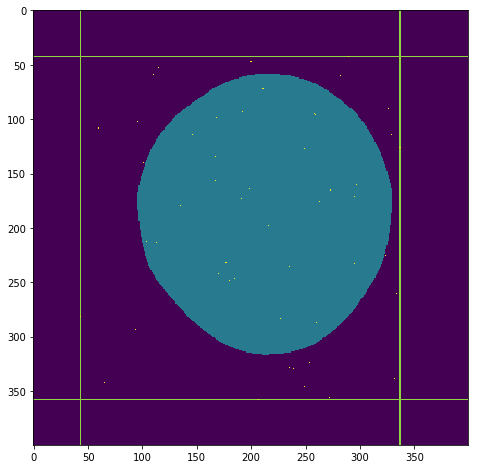

In [64]:
plt.imshow(f)

In [69]:
# from solution thread
%%time
xvalues = np.arange(x_max)
yvalues = np.arange(y_max)
xx, yy = np.meshgrid(xvalues, yvalues)

layers = []
for coord in points:
    mdists = np.abs(xx - coord[0]) + np.abs(yy - coord[1])
    layers.append(mdists)
    
dist_arr = np.array(layers)
tot_dists = dist_arr.sum(axis=0)
print((tot_dists < 10000).sum())

46554
CPU times: user 94 ms, sys: 59 ms, total: 153 ms
Wall time: 172 ms


In [75]:
xx.shape, yy.shape

((337, 358), (337, 358))

In [77]:
xx

array([[  0,   1,   2, ..., 355, 356, 357],
       [  0,   1,   2, ..., 355, 356, 357],
       [  0,   1,   2, ..., 355, 356, 357],
       ...,
       [  0,   1,   2, ..., 355, 356, 357],
       [  0,   1,   2, ..., 355, 356, 357],
       [  0,   1,   2, ..., 355, 356, 357]])

In [76]:
yy

array([[  0,   0,   0, ...,   0,   0,   0],
       [  1,   1,   1, ...,   1,   1,   1],
       [  2,   2,   2, ...,   2,   2,   2],
       ...,
       [334, 334, 334, ..., 334, 334, 334],
       [335, 335, 335, ..., 335, 335, 335],
       [336, 336, 336, ..., 336, 336, 336]])